In [1]:
from pathlib import Path

from dataset import ImageDataset

dataset = ImageDataset(Path("data_col_public/"))

In [2]:
len(dataset)

4700

In [3]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

train_transform = A.Compose(
    [
        A.Resize(600, 420),
        A.RandomCrop(512, 384),  # 4x3
        A.HorizontalFlip(p=0.5),
        A.Rotate(limit=30, p=0.5),
        A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.2),
        A.Normalize(normalization="min_max"),
        ToTensorV2(),
    ],
    additional_targets={"rgb_image": "image"},
)

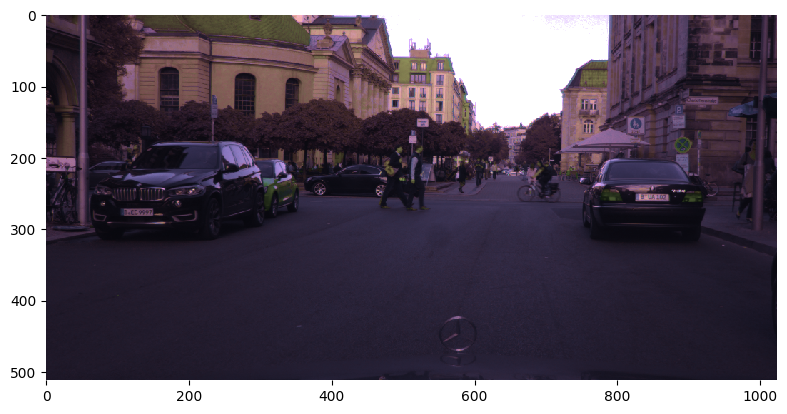

In [4]:
import matplotlib.pyplot as plt


def ishow(
    img, cmap="viridis", title="", fig_size=(8, 6), colorbar=False, interpolation="none"
):
    "Function `ishow` displays an image in a new window."

    # extent = (0, img.shape[1], img.shape[0], 0)
    img = img.permute(1, 2, 0).cpu().detach().numpy()
    fig, ax = plt.subplots(figsize=fig_size)
    pcm = ax.imshow(
        img,
        # extent=extent,
        cmap=cmap,
        interpolation=interpolation,
    )

    ax.set_frame_on(False)
    plt.title(title)
    plt.tight_layout()
    if colorbar:
        fig.colorbar(pcm, orientation="vertical")
    plt.show()


ishow(dataset[0][1])

In [5]:
def show_augmentations(ds, idx, n_samples=3):
    figure = plt.figure(figsize=(12, 8))

    rows = n_samples
    cols = 2

    for i in range(1, rows + 1):
        gray, rgb = ds[idx]

        gray_np = gray.permute(1, 2, 0).cpu().detach().numpy()
        rgb_np = rgb.permute(1, 2, 0).cpu().detach().numpy()

        if gray_np.min() < 0 or gray_np.max() > 1:
            print(
                f"The image values were shifted to the range (0, 1). The original range is ({gray_np.min():.04f}, {gray_np.max():.04f})"
            )
            gray_np = (gray_np - gray_np.min()) / (gray_np.max() - gray_np.min())
            rgb_np = (rgb_np - rgb_np.min()) / (rgb_np.max() - rgb_np.min())

        figure.add_subplot(rows, cols, i * 2 - 1)
        plt.axis("off")
        plt.imshow(
            gray_np, cmap="gray"
        )  # if you don't use cmap="gray", matplotlib will use viridis

        figure.add_subplot(rows, cols, i * 2)
        plt.axis("off")
        plt.imshow(rgb_np)

    plt.suptitle(f"Sample No {idx}")
    plt.tight_layout()
    plt.show()


In [6]:
dataset = ImageDataset(Path("data_col_public/"), train_transform)

The image values were shifted to the range (0, 1). The original range is (-0.0000, 1.0000)
The image values were shifted to the range (0, 1). The original range is (-0.0000, 1.0000)


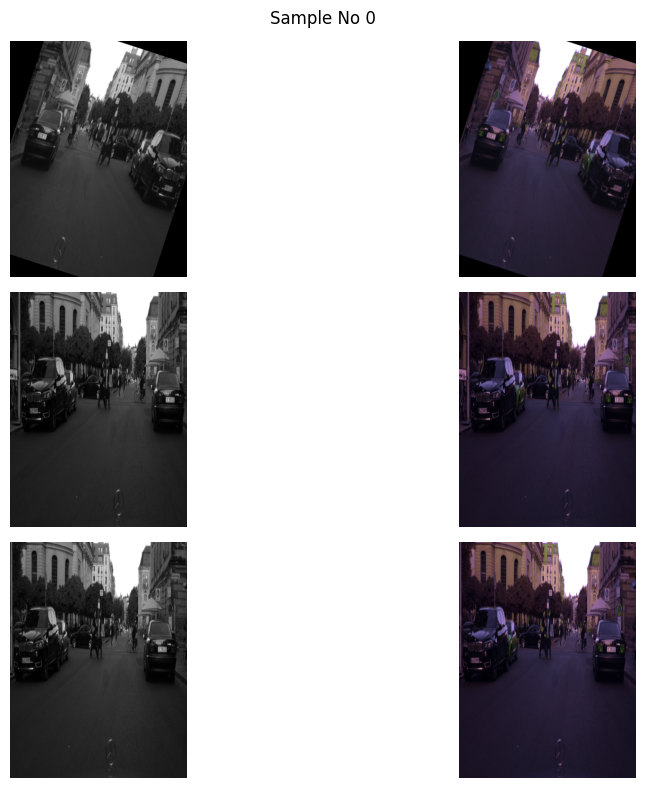

In [7]:
show_augmentations(dataset, 0)

In [8]:
from network import DownBlock

x = dataset[0][0]

d1 = DownBlock(1, 64, False)
d2 = DownBlock(64, 64)
d3 = DownBlock(64, 128)
d4 = DownBlock(128, 256)
d5 = DownBlock(256, 512)


In [9]:
x = x.unsqueeze(0)

In [10]:
x.shape

torch.Size([1, 1, 512, 384])

In [11]:
from torch.utils.data import random_split

train_size, test_size = (
    int(len(dataset) * 0.85),
    len(dataset) - (int(len(dataset) * 0.85)),
)


train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_size, val_size = (
    int(len(train_dataset) * 0.90),
    len(train_dataset) - (int(len(train_dataset) * 0.90)),
)


train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])


In [12]:
import torch
from torch.utils.data import DataLoader

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


class WrappedDataLoader:
    def __init__(self, dataloader, device):
        self.dataloader = dataloader
        self.device = device

    def __len__(self):
        return len(self.dataloader)

    def __iter__(self):  # send only one batch to the device every iteration
        batches = iter(self.dataloader)
        for x, y in batches:
            yield x.to(self.device), y.to(self.device)


bs = 8

train_dataloader = WrappedDataLoader(DataLoader(train_dataset, batch_size=bs), device)
val_dataloader = WrappedDataLoader(
    DataLoader(val_dataset, batch_size=bs, shuffle=True), device
)
test_dataloader = WrappedDataLoader(DataLoader(test_dataset, batch_size=bs), device)


In [13]:
for inputs, targets in train_dataloader:
    print(inputs.shape)
    print(targets.shape)
    break

torch.Size([8, 1, 512, 384])
torch.Size([8, 3, 512, 384])


In [14]:
from network import Discriminator, Generator

G = Generator()
D = Discriminator()

In [15]:
from network import discriminator_loss, generator_loss

generator_output = G(inputs)
discriminator_real_output = D(inputs.repeat(1, 3, 1, 1), targets)
discriminator_generated_output = D(inputs.repeat(1, 3, 1, 1), generator_output)

total_G_loss, G_loss, G_l1_loss = generator_loss(
    discriminator_generated_output, generator_output, targets
)
D_loss = discriminator_loss(discriminator_real_output, discriminator_generated_output)


D_loss.backward()

In [ ]:
from dataclasses import dataclass
from pathlib import Path

import torch
from torch import Tensor
from torch.optim import Optimizer
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm

from dataset import WrappedDataLoader
from network import Discriminator, Generator, discriminator_loss, generator_loss

torch.autograd.set_detect_anomaly(True)


@dataclass
class config:
    lr: float = 0.0002
    momentum_betas: tuple[float, float] = (0.5, 0.999)


def generate_image(
    model: Generator, input: Tensor, target: Tensor, plot_subtitle: str = ""
):
    # input has a shape C x H x W
    # target has a shape C x H x W
    predicted = model(input.unsqueeze(0))  # add a batch dimension
    plt.figure(figsize=(15, 15))

    input_np = input.permute(1, 2, 0).cpu().detach().numpy()
    target_np = target.permute(1, 2, 0).cpu().detach().numpy()
    predicted_np = predicted.squeeze().permute(1, 2, 0).cpu().detach().numpy()

    display_list = [input_np, target_np, predicted_np]
    title = ["Input Image", "Ground Truth", "Predicted Image"]

    for i in range(3):
        plt.subplot(1, 3, i + 1)

        plt.title(title[i])
        if title[i] == "Input Image":
            plt.imshow(display_list[i] * 0.5 + 0.5, cmap="gray")
        else:
            plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis("off")
    plt.suptitle(plot_subtitle)


def fit(
    G: Generator,
    D: Discriminator,
    epochs: int,
    train_dataloader: DataLoader,
    val_dataloader: DataLoader,
    optimizer_G: Optimizer,
    optimizer_D: Optimizer,
    input_to_vizu: Tensor,
    target_to_vizu: Tensor,
    device: torch.device,
) -> tuple[list[float], list[float]]:
    G_train_losses: list[float] = []
    L1_train_losses: list[float] = []
    D_train_losses: list[float] = []

    G_val_losses: list[float] = []
    L1_val_losses: list[float] = []
    D_val_losses: list[float] = []

    for epoch in range(epochs):
        G.train()
        D.train()

        for inputs, targets in tqdm(train_dataloader):
            step_result = fit_step(G, D, optimizer_G, optimizer_D, inputs, targets)

            # graph variables
            G_train_losses.append(step_result.total_G_loss.cpu())
            D_train_losses.append(step_result.D_loss.cpu())
            L1_train_losses.append(step_result.G_l1_loss.cpu())

        G.eval()
        D.eval()
        with torch.no_grad():
            for inputs, targets in tqdm(val_dataloader):
                step_result = fit_step(
                    G, D, None, None, inputs, targets
                )  # optimizers are none -> don't update

                # graph variables
                G_val_losses.append(step_result.total_G_loss)
                D_val_losses.append(step_result.D_loss)
                L1_val_losses.append(step_result.G_l1_loss)

        # print training

        print(
            f"Epoch: {epoch}, train_G_loss: {G_train_losses[-1]:.3f} | train_L1_loss: {L1_train_losses[-1]:.3f} | train_D_loss: {D_train_losses[-1]:.3f}"
        )

        print(
            f"Epoch: {epoch}, val_G_loss: {G_val_losses[-1]:.3f} | val_L1_loss: {L1_val_losses[-1]:.3f} | val_D_loss: {D_val_losses[-1]:.3f}"
        )
        print(inputs[-1].shape)
        generate_image(G, input_to_vizu, target_to_vizu, f"epoch: {epoch}")
    print("Training finished!")
    return G_train_losses, D_train_losses


@dataclass
class FitStepResult:
    total_G_loss: float
    G_loss: float
    G_l1_loss: float
    D_loss: float


bce = torch.nn.BCELoss()
l1 = torch.nn.L1Loss()


def fit_step(
    G: Generator,
    D: Discriminator,
    optimizer_G: Optimizer | None,
    optimizer_D: Optimizer | None,
    inputs: Tensor,
    targets: Tensor,
):
    generator_output = G(inputs)

    inputs = inputs.repeat(1, 3, 1, 1)

    discriminator_real_output = D(inputs, targets)
    discriminator_generated_output = D(inputs, generator_output)

    total_G_loss, G_loss, G_l1_loss = generator_loss(
        discriminator_generated_output, generator_output, targets
    )
    D_loss = discriminator_loss(
        discriminator_real_output, discriminator_generated_output
    )

    with torch.autograd.detect_anomaly():
        if optimizer_G is not None:
            optimizer_G.zero_grad()
            total_G_loss.backward()
            optimizer_G.step()

    if optimizer_D is not None:
        optimizer_D.zero_grad()
        D_loss.backward()
        optimizer_D.step()

    return FitStepResult(total_G_loss, G_loss, G_l1_loss, D_loss)

In [ ]:
from dataclasses import dataclass
from pathlib import Path

import torch
from torch import Tensor
from torch.optim import Adam, Optimizer
from torch.utils.data import DataLoader, Dataset, random_split

from dataset import WrappedDataLoader
from network import Discriminator, Generator, discriminator_loss, generator_loss


def split_dataset(
    dataset: Dataset, test_size: float = 0.15, val_size: float = 0.10
) -> tuple[Dataset, Dataset, Dataset]:
    train_ratio = 1.0 - test_size

    train_size, test_size = (
        int(len(dataset) * train_ratio),
        len(dataset) - (int(len(dataset) * train_ratio)),
    )

    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
    val_ratio = 1.0 - val_size
    train_size, val_size = (
        int(len(train_dataset) * val_ratio),
        len(train_dataset) - (int(len(train_dataset) * val_ratio)),
    )

    train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

    return (train_dataset, val_dataset, test_dataset)


def training(dataset_path: Path) -> None:
    """Performs training on the given dataset.

    Args:
        dataset_path: Path to the dataset.

    Saves:
        - model.pt (trained model)
        - learning_curves.png (learning curves generated during training)
        - model_architecture.png (a scheme of model's architecture)
    """
    # Check for available GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Computing with {}!".format(device))

    batch_size = 4

    dataset = ImageDataset(dataset_path, train_transform, n=500)

    train_dataset, val_dataset, _ = split_dataset(dataset, 0.15, 0.1)

    train_dataloader = WrappedDataLoader(
        DataLoader(train_dataset, batch_size=batch_size), device
    )
    val_dataloader = WrappedDataLoader(
        DataLoader(val_dataset, batch_size=batch_size, shuffle=True), device
    )

    D = Discriminator()
    G = Generator()

    # define optimizer and learning rate
    optimizer_G = Adam(G.parameters(), lr=config.lr, betas=config.momentum_betas)
    optimizer_D = Adam(D.parameters(), lr=config.lr, betas=config.momentum_betas)
    # define loss function

    # train the network
    train_losses, val_losses = fit(
        G,
        D,
        3,
        train_dataloader,
        val_dataloader,
        optimizer_G,
        optimizer_D,
        val_dataset[0][0],
        val_dataset[0][1],
        device,
    )


Computing with cpu!


  0%|          | 0/96 [00:00<?, ?it/s]/tmp/ipykernel_185762/3795115919.py:144: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():
100%|██████████| 11/11 [00:04<00:00,  2.63it/s]


Epoch: 0, train_G_loss: 106.643 | train_L1_loss: 0.577 | train_D_loss: 100.774
Epoch: 0, val_G_loss: 96.821 | val_L1_loss: 0.536 | val_D_loss: 111.052
torch.Size([1, 512, 384])


100%|██████████| 11/11 [00:04<00:00,  2.73it/s]


Epoch: 1, train_G_loss: 108.782 | train_L1_loss: 0.590 | train_D_loss: 99.422
Epoch: 1, val_G_loss: 106.855 | val_L1_loss: 0.609 | val_D_loss: 107.446
torch.Size([1, 512, 384])


100%|██████████| 11/11 [00:04<00:00,  2.65it/s]


Epoch: 2, train_G_loss: 107.265 | train_L1_loss: 0.582 | train_D_loss: 100.681
Epoch: 2, val_G_loss: 100.460 | val_L1_loss: 0.551 | val_D_loss: 108.579
torch.Size([1, 512, 384])
Training finished!


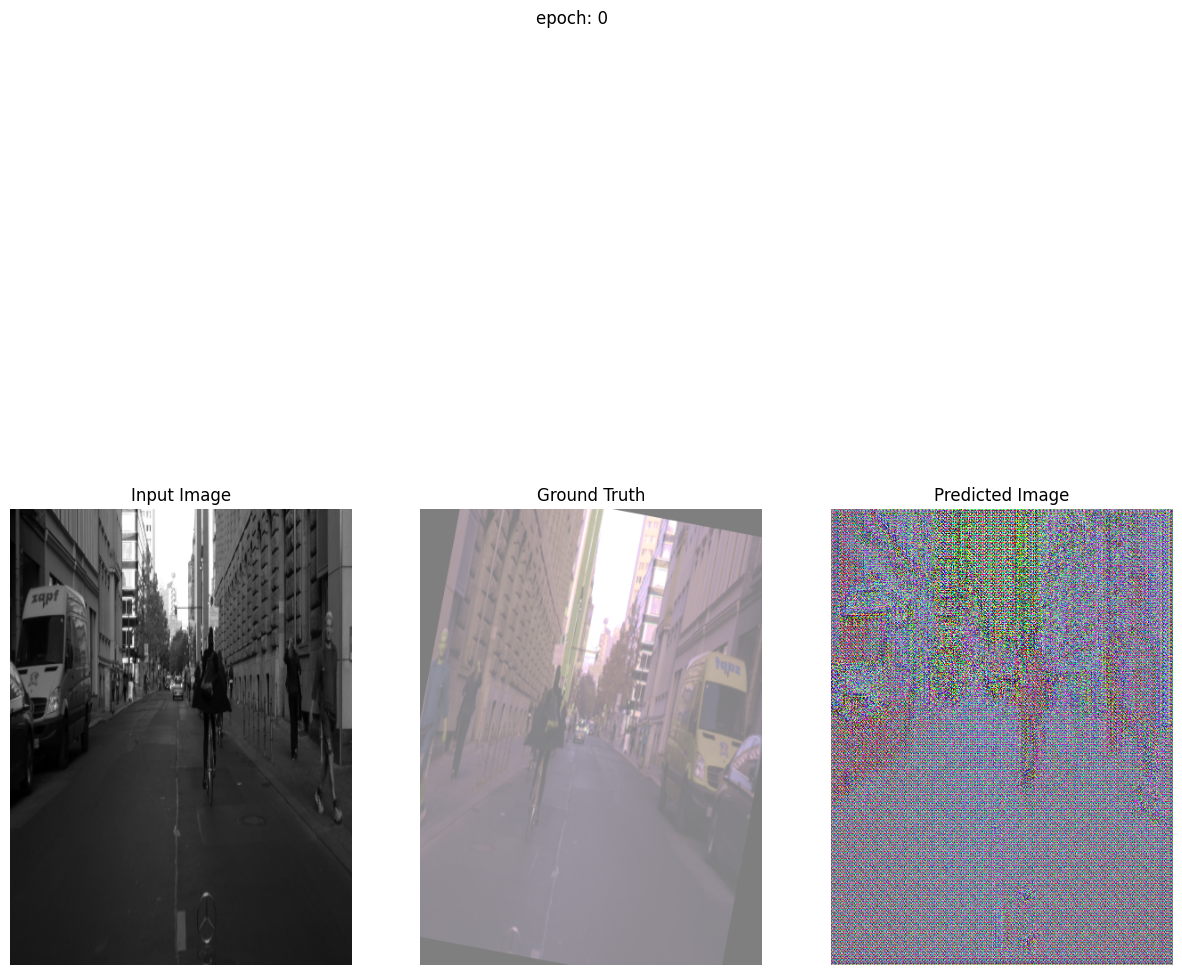

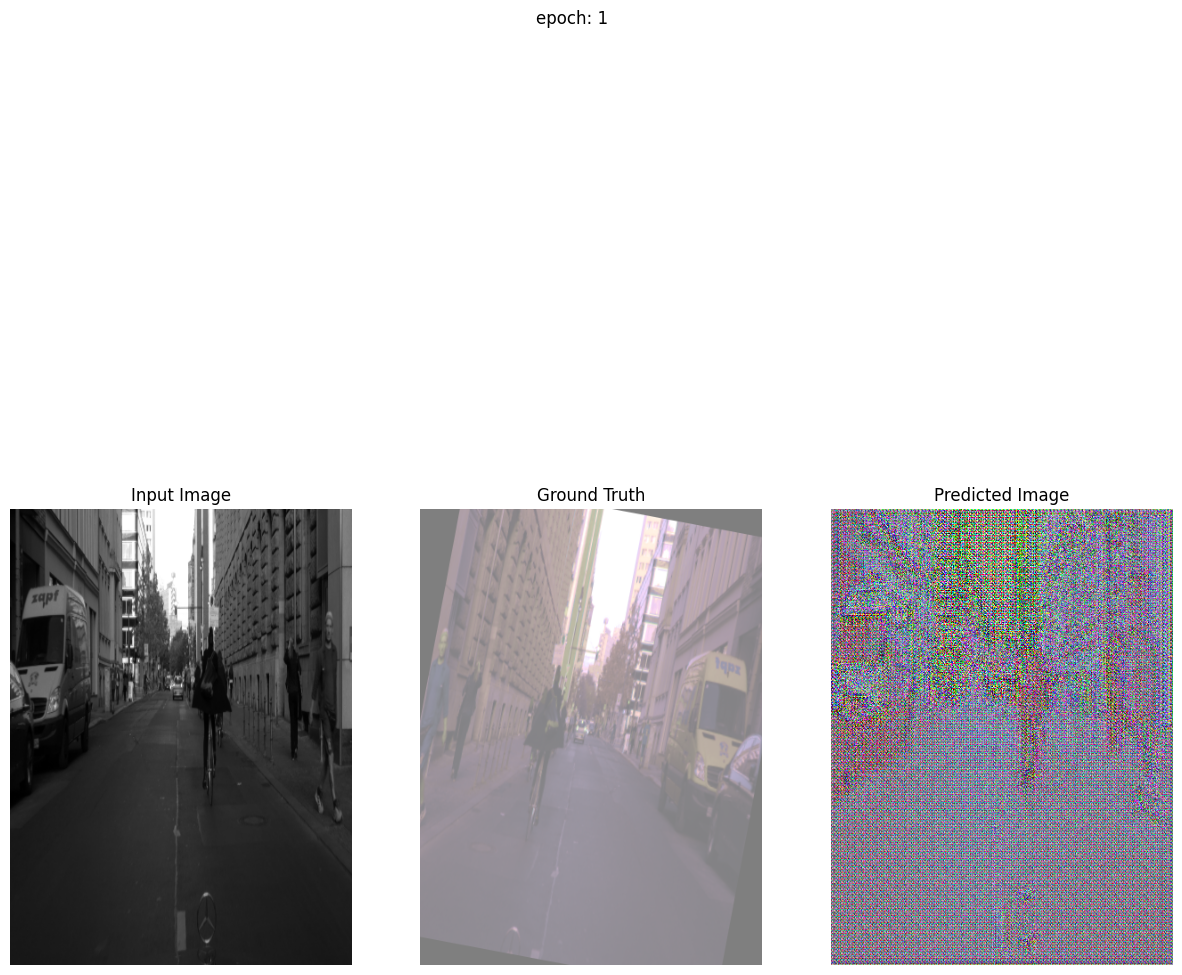

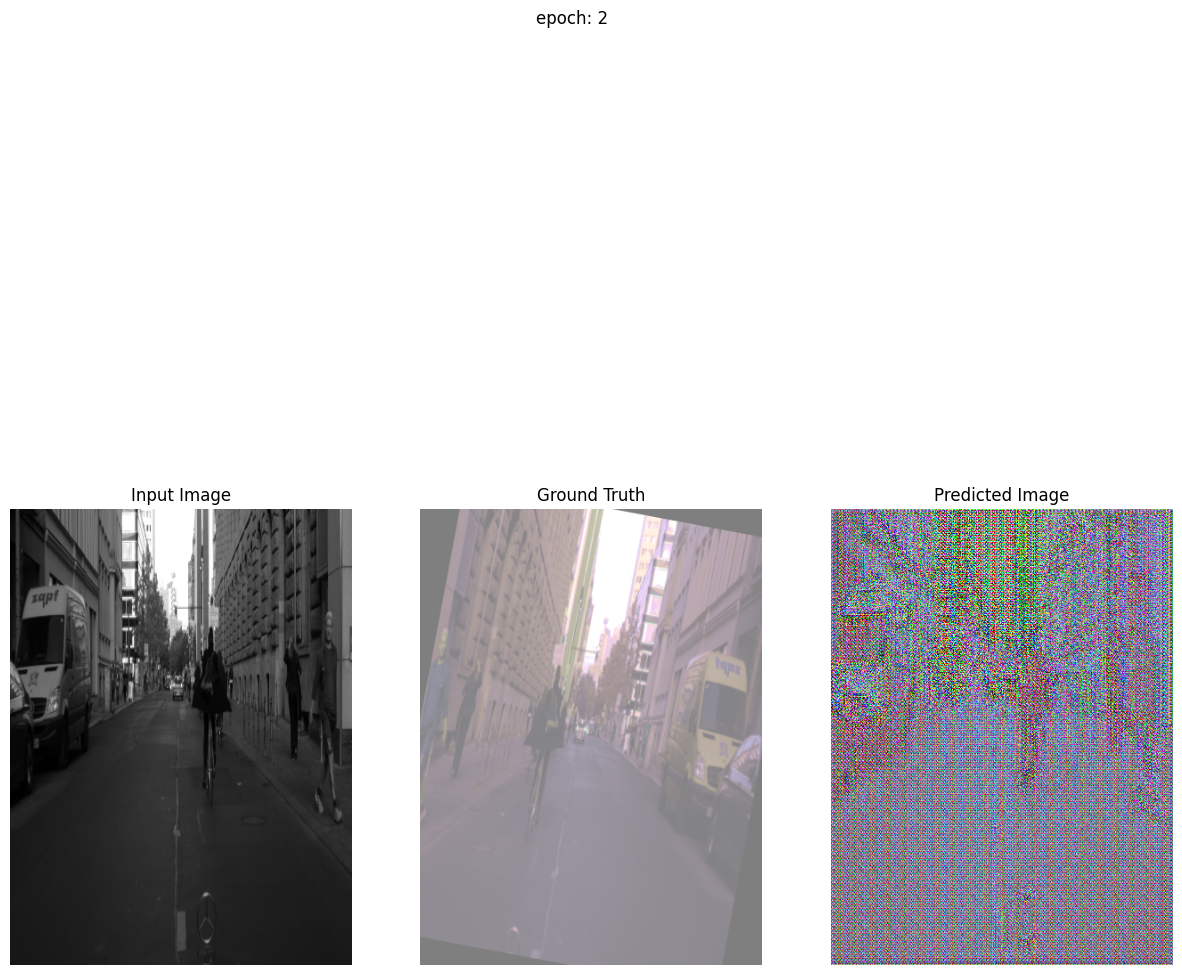

In [54]:
training(Path("data_col_public/"))

In [ ]:
dataset = ImageDataset(Path("data_col_public/"), train_transform)

In [29]:
dataset[0][0].max()

tensor(1.)

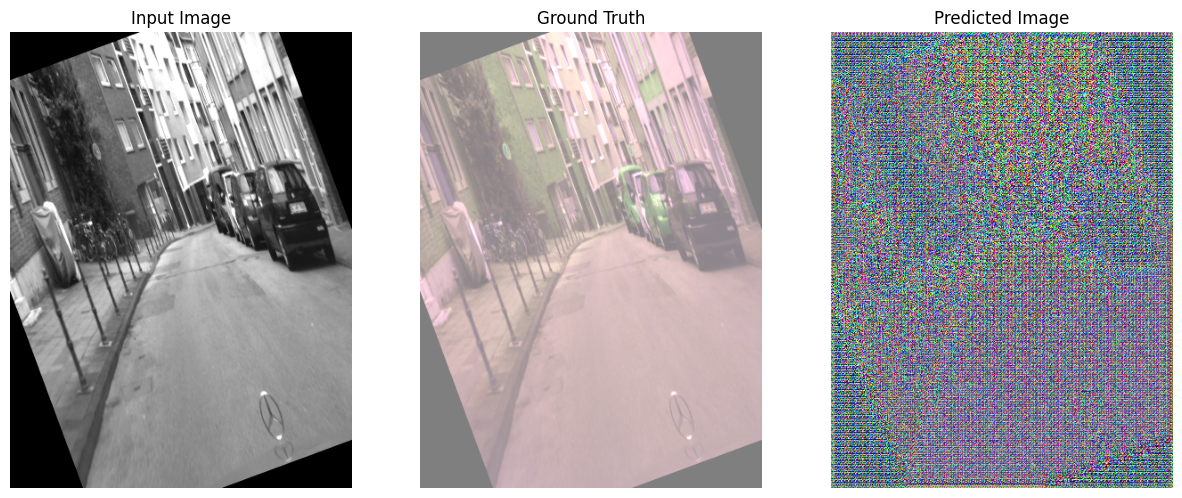

In [23]:
predicted.shape

torch.Size([1, 3, 512, 384])